In [6]:
import numpy as np
from qiskit import QuantumCircuit
import torch
import matplotlib.pyplot as plt
import pdflatex
import pylatexenc
import gym
import torch
import torch.nn as nn
import torch.optim as optim
import random
from collections import deque

# Quick Check to see if my GPU is being detected
device = torch.device("cuda" if torch.cuda.is_available() else  "cpu")
print("Using ", device)
print(gym.__version__)

Using  cuda
0.26.1


# Classes used for Modelling

In [7]:

# Defining a simple FF Network for cartpole
class Classical_DQN(nn.Module):
    def __init__ (self, state_size, action_size):
        super(Classical_DQN,self).__init__()

        self.layer_1 = nn.Linear(state_size, 256)
        self.layer_2 = nn.Linear(256,256)
        self.output  = nn.Linear(256, action_size)

    def forward(self, x):
        x = nn.functional.relu(self.layer_1(x))
        x = nn.functional.relu(self.layer_2(x))
        return self.output(x)
    
    
    

class ReplayBuffer(object):
    def __init__(self, capacity):
        self.buffer = deque(maxlen=capacity)  # FIFO queue to hold experiences

    # Add an experience to the buffer
    def add(self, state, action, reward, next_state, done):
        
        self.buffer.append((state, action, reward, next_state, done))

    # Sample an experience from the buffer
    def sample(self, batch_size):

        return random.sample(self.buffer, batch_size)

    # Return the currenlength of the buffer
    def size(self):
        return len(self.buffer)
    




# Environment Setup

In [ ]:
env = gym.make("CartPole-v0")
state_size = env.observation_space.shape[0]
action_size = env.action_space.n

# Just for myself
#print("state space dim: %f", env.observation_space.shape[0])
#print("Action state size: %f", action_size)

# Creating live and target models
live_model = Classical_DQN(state_size, action_size).to(device)
optimizer = optim.Adam(live_model.parameters(), lr=0.001)
criterion = torch.nn.MSELoss()

target_model = Classical_DQN(state_size, action_size).to(device)
target_model.load_state_dict(live_model.state_dict())
target_model.eval()  

print(live_model)


print("Environment and models are set up.")

c:\Users\Saad\miniconda3\envs\QRL\lib\site-packages\gym\envs\registration.py:555: UserWarning: WARN: The environment CartPole-v0 is out of date. You should consider upgrading to version `v1`.
  logger.warn(


state space dim: %f 4
Action state size: %f 2
Classical_DQN(
  (layer_1): Linear(in_features=4, out_features=256, bias=True)
  (layer_2): Linear(in_features=256, out_features=256, bias=True)
  (output): Linear(in_features=256, out_features=2, bias=True)
)
Environment and models are set up.


In [9]:
# The actual trainnig loop for our Deep Q model

def train_DQN(env, epsilon, epsilon_decay, num_episodes, replay_buffer, batch_size, target_update_freq, epsilon_min, gamma):

    rewards_list = []
    
    mean_reward_list = []
    
    for episode in range(num_episodes):
        state, info = env.reset()
        state = torch.FloatTensor(state).unsqueeze(0).to(device)
        total_reward = 0

        for t in range(1, 10000):

            # Epsilon-greedy action selection
            if random.random() > epsilon:
                with torch.no_grad():
                    q_values = live_model(state)
                    action = q_values.max(1)[1].item()
            else:
                action = env.action_space.sample()

   
            next_state, reward, terminated, truncated, info = env.step(action)
            done = terminated or truncated
            next_state = torch.FloatTensor(next_state).unsqueeze(0).to(device)
            total_reward += reward


            replay_buffer.add(state, action, reward, next_state, done)


            state = next_state


            if replay_buffer.size() >= batch_size:

                transitions = replay_buffer.sample(batch_size)
                batch_state, batch_action, batch_reward, batch_next_state, batch_done = zip(*transitions)


                batch_state = torch.cat(batch_state).to(device)          
                batch_next_state = torch.cat(batch_next_state).to(device)  # Shape: [batch_size, state_dim] I believe


                batch_action = torch.tensor(batch_action, dtype=torch.long).unsqueeze(1).to(device)  # Shape: [batch_size, 1]
                batch_reward = torch.tensor(batch_reward, dtype=torch.float).unsqueeze(1).to(device)  # Shape: [batch_size, 1]
                batch_done = torch.tensor(batch_done, dtype=torch.float).unsqueeze(1).to(device)      # Shape: [batch_size, 1]


                q_values = live_model(batch_state).gather(1, batch_action)
                with torch.no_grad():
                    max_next_q_values = target_model(batch_next_state).max(1)[0].unsqueeze(1)
                    target_q_values = batch_reward + gamma * max_next_q_values * (1 - batch_done)


                loss = criterion(q_values, target_q_values)
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

            if done:
                break


        if epsilon > epsilon_min:
            epsilon *= epsilon_decay
            epsilon = max(epsilon_min, epsilon)


        if episode % target_update_freq == 0:
            target_model.load_state_dict(live_model.state_dict())

        rewards_list.append(total_reward)
        mean_reward = np.mean(rewards_list)
        mean_reward_list.append(mean_reward)
    
    

    plt.figure(figsize=(12, 6))
    plt.plot(rewards_list, label='Total Reward per Episode')
    plt.plot(mean_reward_list, label='Total Reward per Episode')
    plt.xlabel('Episode')
    plt.ylabel('Total Reward')
    plt.title('Training Classical DQN on CartPole')
    plt.legend()
    plt.show()

# Hyperparameter Tuning 

In [ ]:


# Create the training buffer for experience replay
buffer_capacity = 10000
replay_buffer = ReplayBuffer(buffer_capacity)

gamma = 0.99              # Discount factor for future rewards
epsilon = 1.0             # Initial exploration rate
epsilon_decay = 0.99    # Decay rate for epsilon
epsilon_min = 0.005        # Minimum exploration rate
batch_size = 128           # Number of experiences sampled per update
target_update_freq = 10   # Frequency to update the target network
num_episodes = 300        # Total number of episodes to train

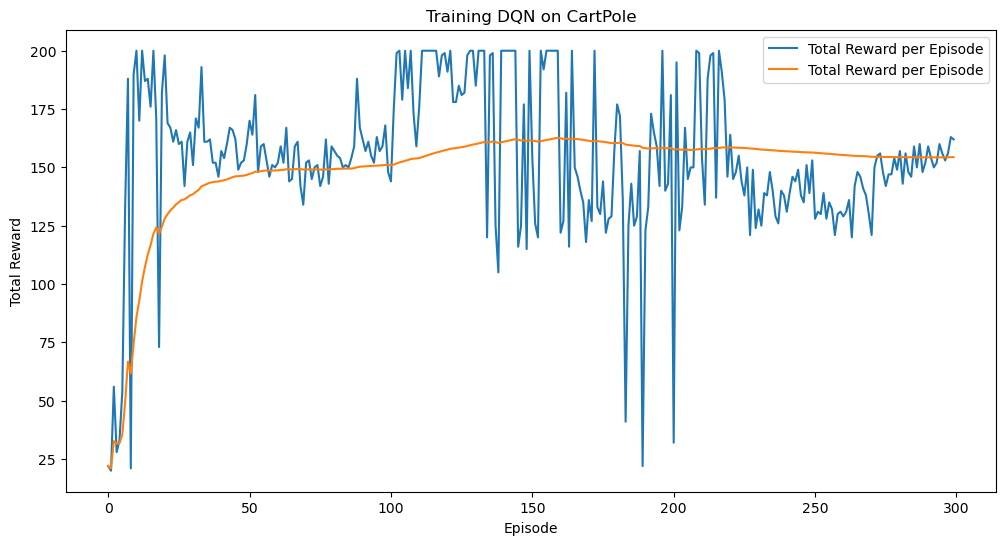

In [141]:
train_DQN(env, epsilon, epsilon_decay, num_episodes, replay_buffer, batch_size, target_update_freq, epsilon_min, gamma)